In [14]:
# ==============================
# Step 1 – Import libraries
# ==============================
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Country code mapping dictionary
countries = {
    'India': 162,
    'United States': 1,
    'United Kingdom': 215,
    'Australia': 14,
    'Canada': 37,
    'Brazil': 30,
    'United Arab Emirates': 178,
    'South Africa': 156,
    'New Zealand': 166,
    'Singapore': 148,
    'Malaysia': 137,
    'Germany': 81,
    'France': 82,
    'Italy': 94,
    'Spain': 229,
    'Netherlands': 109,
    'Switzerland': 206,
    'Thailand': 213,
    'China': 39,
    'Japan': 60
}


In [15]:
# ==============================
# Step 2 – Load dataset
# ==============================
data = pd.read_csv("Dataset .csv")
print("Initial shape:", data.shape)
print(data.head())

Initial shape: (9551, 21)
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mand

In [16]:
# ==============================
# Step 3 – Data Cleaning
# ==============================
# Drop irrelevant text column if exists
if 'Switch to order menu' in data.columns:
    data = data.drop(columns=['Switch to order menu'])

# Fill missing numeric values with mean
data = data.fillna(data.mean(numeric_only=True))

In [17]:
# ==============================
# Step 4 – Features & Target
# ==============================
# Keep only important features
selected_features = [
    'Country Code',
    'Longitude',
    'Latitude',
    'Average Cost for two',
    'Has Table booking',
    'Has Online delivery'
]

X = data[selected_features]
y = data['Aggregate rating']

In [18]:
# ==============================
# Step 5 – Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (7640, 6) Test shape: (1911, 6)


In [19]:
# ==============================
# Step 6 – Preprocessing + Model Pipeline
# ==============================
numeric_features = ['Longitude', 'Latitude', 'Average Cost for two']
categorical_features = ['Country Code', 'Has Table booking', 'Has Online delivery']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)

# Save pipeline and feature names for Streamlit
joblib.dump(pipeline, "restaurant_rating_model.pkl")
joblib.dump(list(X.columns), "feature_columns.pkl")
print("✅ Model and feature columns saved successfully!")

✅ Model and feature columns saved successfully!


In [20]:
# ==============================
# Step 7 – Model Evaluation
# ==============================
y_pred_rf = pipeline.predict(X_test)

print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")

Random Forest R²: 0.4241
Random Forest MSE: 1.3108


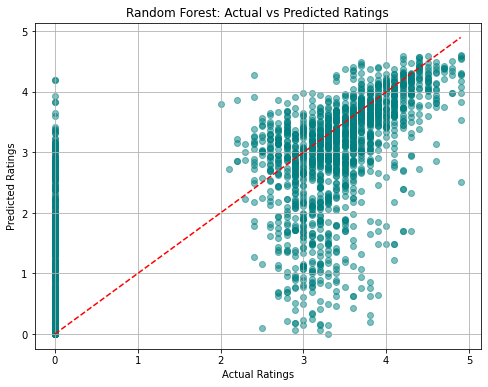

In [21]:
# ==============================
# Step 8 – Visualization
# ==============================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Random Forest: Actual vs Predicted Ratings')
plt.grid(True)
plt.show()

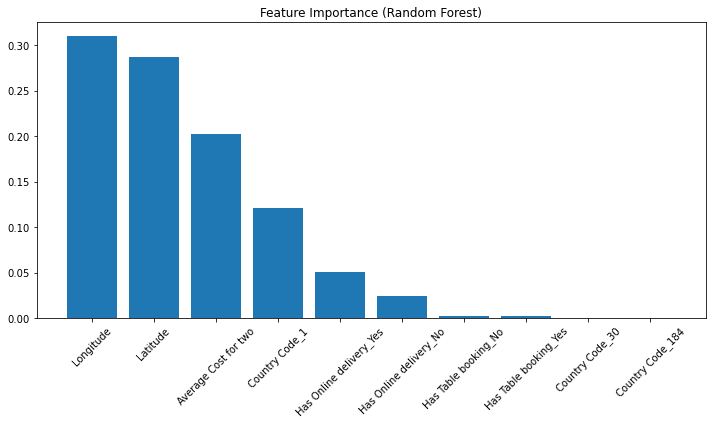

In [22]:
# ==============================
# Step 9 – Feature Importance Plot
# ==============================
# Extract feature names after one-hot encoding
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = list(ohe.get_feature_names_out(categorical_features))
all_features = numeric_features + encoded_cat_features

# Get feature importances from Random Forest
importances = pipeline.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

n_features_to_plot = min(10, len(importances))

plt.figure(figsize=(10,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(n_features_to_plot), importances[indices[:n_features_to_plot]], align='center')
plt.xticks(range(n_features_to_plot), [all_features[i] for i in indices[:n_features_to_plot]], rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# ==============================
# Step 10 – Prediction Functions (fixed)
# ==============================
def interactive_predict_with_country_list(model):
    print("\nSelect country from the list below:")

    # Display all countries
    for i, country in enumerate(countries.keys(), 1):
        print(f"{i}. {country}")

    # Ask user to input number choice
    choice = int(input("Enter the number corresponding to the country: "))
    country_name = list(countries.keys())[choice - 1]
    country_code = countries[country_name]

    lon = float(input("Longitude: "))
    lat = float(input("Latitude: "))
    cost = float(input("Average Cost for two: "))
    table_booking = input("Has Table booking (Yes/No): ").capitalize()
    online_delivery = input("Has Online delivery (Yes/No): ").capitalize()

    input_df = pd.DataFrame({
        'Country Code': [str(country_code)],
        'Longitude': [lon],
        'Latitude': [lat],
        'Average Cost for two': [cost],
        'Has Table booking': [table_booking],
        'Has Online delivery': [online_delivery]
    })

    prediction = model.predict(input_df)
    print(f"\nPredicted Rating: {round(prediction[0], 2)}")


# Run default prediction to test pipeline works
default_test_case(pipeline)
interactive_predict_with_country_list(pipeline)  # or model variable you loaded

# Uncomment below to run interactive prediction in your Jupyter cell
# interactive_predict_simplified(pipeline)

Predicted Rating (default case): 4.31

Select country from the list below:
1. India
2. United States
3. United Kingdom
4. Australia
5. Canada
6. Brazil
7. United Arab Emirates
8. South Africa
9. New Zealand
10. Singapore
11. Malaysia
12. Germany
13. France
14. Italy
15. Spain
16. Netherlands
17. Switzerland
18. Thailand
19. China
20. Japan
Enter the number corresponding to the country: 1
Longitude: 14
Latitude: 32
Average Cost for two: 1
Has Table booking (Yes/No): 1
Has Online delivery (Yes/No): 1

Predicted Rating: 4.08
